# Please install the yellowbrick package first

In [ ]:
pip install yellowbrick

In [1]:
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
sns.set_palette('husl')

from sklearn.preprocessing import LabelEncoder, StandardScaler, QuantileTransformer, MinMaxScaler, Normalizer
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer, MissingIndicator
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA
from math import isclose

from yellowbrick.cluster import SilhouetteVisualizer, KElbowVisualizer, silhouette_visualizer
from yellowbrick.cluster.icdm import InterclusterDistance
from yellowbrick.datasets import load_nfl


In [2]:
# %logstop
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
matplotlib.rcParams['figure.dpi'] = 144
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interact, IntSlider, FloatSlider, fixed

# Problem Discription

- To obtain the optimal clustering algorithm for unsupervised learning of water molecules. 

- The water.csv file contains 1001 snapshots of 250 water molecules. i.e. each line has coordinates of 750 atoms (making total 2250 columns) and 2251st column is called flag which is not relevant in the beginning.

- Since these are coordinates, the feature vector of dim 2250 can be reshaped into 750 X 3 matrix.

- This essentially makes it a 750 dimensional array of 3-d vectors.

- We will take the first vector and subtract it from all the vectors in the snapshot (reason expLained later). The feature vectors will be reshaped back to vector of dim 2250.

- Clustering algorithm will be run on 1001 feature vectors of dim 2250. We will perform elbow and silhouette analysis and identify distinct clusters in 1001 snapshots.

In [3]:
# Load Training Data From Disc

data = pd.read_csv("water.csv", header=None)

FileNotFoundError: [Errno 2] File water.csv does not exist: 'water.csv'

- Here, I'll take a brief look at the data for the purpose of exploratory analysis and overview data.

In [ ]:
data.head()

In [ ]:
data.tail()

## Are there any Missing Data?

- An important question to ask is how many observations, if any, have missing data and what proportion of entire set this represents

In [ ]:
print("Proportion of missing values")
print(data.isnull().sum().sum()*100/len(data))

print("Proportion of missing values")
print(data.isna().sum().sum()*100/len(data))

- The data has no missing values

## Slice Out The Flag Column

- Since the 2251st column are the flag labels, they will be dropped from the dataframe and set as $Flags$ 

In [ ]:
flags = data.iloc[:,2250]

In [ ]:
data = data.drop(columns=[2250])

## Feature Engineering

#### Obtain the Feature Space

- The new DataFrame has 2250 features for 1001 snapshots

- The objective is to reshape the feature space to a $750$ $X$ $3$ equavalent to a dimension corresposing to $Atoms$ $X$ $Coordinates$

In [ ]:
# Convert the dataframe into an array to allow easy reshaping

X = data.to_numpy()

In [ ]:
# reshape feature vectors into 750 X 3 dimensions

X = X.reshape((1001, 750, 3))

- In the new configuration, the shape $1001$ $X$ $750$ $X$ $3$ is equivalent to $Snapshots$ $X$ $Atoms$ $X$ $Coordinates$

- Now, I'll subtract the first coordinates from all coordinates in order to create a reference coordinate.

- This reference cooridinate will have values $0$, $0$, $0$

In [ ]:
# Initialize new feature matrix as 3d matrix of shape (1001, 750, 3), for feature transformation

X_new = np.zeros((X.shape[0], X.shape[1], X.shape[2]))
y_new = np.zeros((X.shape[0], X.shape[1], X.shape[2]))

# loop through all 1001 snapshots (i.e slices in the 3d matrix)
for i in range(0, len(X)):
    # Subtract coordinates in row 0 from coordinates in all other rows
    X_new[i, :, :] = X[i][:, :] - X[i][0, :]
    y_new[i, :, :] = flags[i]

- now, we reshape the feature vectors into a vector or dimensions 2250 for each of the 1001 snapshots

In [ ]:
# Reshape back into (1001, 2250) matrix

X = X_new.reshape((1001, 2250))

#### Data Transformation

- For training pruposes, we require some kind of transformation that will covert the feature space into a more relevant feature space for the clustering algorithm.

- To make this transformation, we consider the irreducible representation of the symmetry group of the raw data. 

- Examples of such symmetry groups for the vector coordinates being delt with here are

$$Rotation$$

$$Translation$$

- These operations when performed on the data sets should maintain invariance of the problem.

- However, we have performed such transformation in prior steps by subtracting the first vector from all other vectors in the snapshot in the $750$ $X$ $3$ representation of the feature vectors. 

- This procedure only creates a reference cooridnate ($0$, $0$, $0$) that doesn't change necessarily the physics.

- Coupled with the fact that each of the feature vectors in the $2250$ dimensional feature space are all $vector$ $coordinates$, which have the physical measurements units, no further transformations need to be done. 

- This is further validated by the fact that the inherent distance measures$-$used to form clusters$-$use $vector$ $coordinates$ in the $Euclidean$ $space$. Since the the data already has such a representation, there's no pressing need for further transformation. 


#### Dimensionality Reduction 

- The feature space has an extremely high dimensionality of 2250 feature vectors. One can therefore intuitively note that obtaining distance measures at such high dimensions is notoriously difficult.  

- More so, the distance between the data points and the origin of the coordinate system grows as a square root of the number of dimensions D, which will in turn lead to divergence of the the Euclidean distance metric employed by most clustering algorithms of interest.

- Since all of these feature vectors may not be necessary for explaining the overall variance (underlying structure)for individual snapshots, it is imporotant to investigate if a reduced set of feature vectors can capture ~$100$% of the overall data structure. 

- This will be done using $Principal$ $Component$ $Analysis$ because the algorithm inherently supports unserpeprvised learning , which is of particular interest in this question. 

- We will call the $Decomposition.PCA()$ method and investe the $cummulative$ $explained$ $variance$ $ratio$ as a function of number of components. 

- Since this automatically sorts the components in order of increasing variance, the first $n$$-$$components$ that results in ~$100$% of the $cummulative$ $explained$ $variance$ $ratio$ will be reserved as the set of new feature vectors

In [4]:
#call PCA method and fit
pca = PCA().fit(X)

# plot cummulative variance (eigenvalues) explained by the first 150 eigenvectors

plt.plot(np.cumsum(pca.explained_variance_ratio_)[0:151])
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

NameError: name 'X' is not defined

##### The curve above gives the cumulative explained variance, which measures how well PCA preserves the content of the data

- This curve quantifies how much of the total, 2250-dimensional variance is contained within the first $N$ $components$. For example, we see that with the snapshoots, the first 10 components contain approximately ~$93$% of the variance, while you need around 150 components to describe close to $100$% of the variance.

- Therfore, we see that a 150-dimensional projection retains a lot of information (as measured by the explained variance) and that we’d need about 150 components to retain ~$100$% of the variance.

- $Why$ $Is$ $The$ $150$$-$$dim$ $vector$ $a$ $reasonable$ $size$ $for$ $the$ $new$ $feature$ $space$? Because the size of the reduced feature space is markedly smaller than the size of the raw feature space, while still achieving ~$100$% explained variance. 

#### Project Data Unto Lower (150-) Dimensional Space

In [5]:
# call PCA method and project raw data into new eigenbasis
pca = PCA(n_components=150)

X_projected = pca.fit_transform(X) 

#check new shape of reduced feature vectors
print(X_projected.shape)

NameError: name 'X' is not defined

## Clustering on Reduced Data

- Here I compare performance of 3 popular clustering algorithms on the data set;

$$Kmeans$$

$$AgglomerativeClustering$$

$$DBSCAN$$

#### KMeans Algorithm -- Centroid Based Clustering

- The $K$-$Means$ algorithm is tested because it is perhaps the simplest algorithm in the group of $Centroid$ $Based$ $Clustering$ algorithms

- A particular disavantage of the $Centroid$ $Based$ $Clustering$ algorithms is that they require the number of clusters to be specified a-priori which is hard to optimize due to inapplicability of cross-validation for clustering

- Here I will vizualize $Silhouette$ $Curves$ for a range of cluster numbers in combinations with the hyperparamters specifying methods for initialization, so as to obtain the optimal number of clusters and initialization method.

- The initialization methods considered are; 

    - " ‘k-means++’ : selects initial cluster centers for k-mean clustering in a smart way to speed up convergence. "

    - " ‘random’: choose n_clusters observations (rows) at random from data for the initial centroids "  source https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html


In [6]:
#initialize number of clusters as a list for looping
n_clusters = list(np.arange(2, 6))

#list for methods of initialization to be considered 
init_method = ["k-means++", "random"]

# dataframe for errors for init_method, n_cluster combinations
kmeans_error = pd.DataFrame(columns=["k-means++", "random"], index=n_clusters, dtype=float)

# save labels to 3d array for  init_method, n_cluster combinations
y_kmeans_pr = np.zeros((len(n_clusters), X_projected.shape[0], len(init_method)))

fig, axs = plt.subplots(nrows=len(n_clusters), ncols=len(init_method), figsize=(14, 14), sharex=True, sharey=True)

for n_idx, n in enumerate(n_clusters):
    for method_idx, method in enumerate(init_method):
        kmeans = KMeans(n_clusters=n, init=method)
        kmeans.fit(X_projected)
        y_kmeans = kmeans.predict(X_projected)
        y_kmeans_pr[n_idx, :, method_idx] = y_kmeans
        kmeans_error.loc[n, method] = kmeans.inertia_
        # Creating SilhouetteVisualizer and assigning it to an axis
        visualizer = SilhouetteVisualizer(kmeans, ax=axs[n_idx, method_idx], is_fitted='auto', legend=True)
        visualizer.fit(X_projected)
        # Setting subplot legends via axis
        axs[n_idx, method_idx].legend([f'{n} clusters, Score={visualizer.silhouette_score_:.3f}'],
                                            loc="upper right", frameon=True, fontsize=10)
        # Setting subplot x and y labels
        axs[n_idx, method_idx].set(xlabel='silhouette coefficient values', ylabel='cluster label')

axs[0, 0].set_title("k-means++")
axs[0, 1].set_title("random")

fig.text(0.5, 0.04, 'Method for Initialization', ha='center', fontsize=16)
fig.text(0.04, 0.5, 'Number of Clusters', va='center', rotation='vertical',fontsize=16)

NameError: name 'X_projected' is not defined

#### Comments

- Since silhouette coefficients near $+$$1$ indicate that the sample is far away from the neighboring clusters and a value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters, and negative values indicate that those samples might have been assigned to the wrong cluster, we can draw the following conlcusions from the $K$$-$$Means$ clustering algorthim;

    - That, at first glance, $n$_$clusters$ values of $2$, $3$, $4$, and $5$ do not yield acceptible clustering of the data due to the presence of clusters with below average silhouette scores and also due to wide fluctuations in the size of the silhouette plots.
    
    - More so, the silhouette analysis doesn't yield significantly differing results for both initialization methods considered.
    
- A plausible reason for the failure of this algorithm could be it's lack of flexiblity. Since the feature space has a high demnsionality, it is possible that the clusters are noncircular, thus, such centroid-based clustering algorithm which can handle only clusters with spherical or ellipsoidal symmetry are likely to provide a very poor fit. 

- Although the clustering algorithm doesn't produce very good fit, it is seen from the plot that the number of clusters with the best score is $3$

#### Visualize K-Means Elbow

- In order to expand the the range of $n$_$clusters$ considered in the algorithm, we will plot the elbow (inertia) curves for a wide range of values. This will also help to consolidate the deductions from the silhouette analysis. 

- To aid direct comparison, the metric used in this plot is the $Calinski$-$Harabasz$ $Index$ which, the ratio of within to between cluster dispersion. The dispersion is defined as the sum of distances squared. 

- Higher scores of this index reflect dense, well separated clusters, which gives a reasonable standard concept of a cluster.

In [ ]:
kmeans_model = KMeans()
n_clusters_range = (2, 12)
visualizer = KElbowVisualizer(kmeans_model, k=n_clusters_range, metric='calinski_harabasz', timings=False, locate_elbow=True)
visualizer.fit(X_projected)
visualizer.show()

#### Comments

- It is evident from the silhouette analysis and the elbow plot that the optimal number of clusters predicted by the  $K$$-$$Means$ clustering algorthim is $3$ since this results in the highest silhouette coefficient (nearest to +1) and $Calinski$-$Harabasz$ score, which by definition indicates highly dense clusters. 


- However, the analysis shows that n_clusters value of $3$ is still a bad pick for the given data due to the presence of clusters with below average silhouette scores and also due to wide fluctuations in the size of the silhouette plots.

- Therefore, this model will be trained with $n$_$clusters$ = $3$ but other clustering algorithms will have to be tested to see if they produce better results/fits.

#### Fitted Model

- $K$-$means$ fittted with $n$_$clusters$ = $3$ and $init$_$method$ = $K$-$means++$

In [7]:
kmeans = KMeans(n_clusters=3, init="k-means++")
kmeans.fit(X_projected)
y_kmeans = kmeans.predict(X_projected)

NameError: name 'X_projected' is not defined

#### Agglomerative Clustering -- Heirachical Clustering

- A reason for the poor performance of the $K$-$Means$ algorithm could be the lack of flexibility in cluster shape coupled with the curse of dimensionality that could lead to the divergence of the Euclidean Distance.

- Since $Heirachical$ $Clustering$ algorithms recursively merge pair of clusters that minimally increases a given linkage distance, it is possible that this resolves the sphere-like clustering therefore having fewer assumptions about the distribution of the data - the only requirement (which $K$-$Means$ also shares) is the distance metric calculated for each pair of clusters.. 

- Therefore, in order to have more control over the shape of cluster assignment, the Agglomerative Clustering algorithm is considered, since it doesnt restrict the cluster to be spherical.

- Here I will vizualize $Silhouette$ $Curves$ for a range of cluster numbers as well as combinations of the hyperparamters specifying the affinity, so as to obtain the optimal number of clusters and distance metric.

- The distance measures considered are; 

    - 'euclidean': Usual square distance between the two vectors (2 norm)."

    - 'manhattan':	Absolute distance between the two vectors (1 norm). 

#### Below is a collapsed cell function for plotting. Please run the cell first

In [ ]:
# yellowbrick.cluster.silhouette
# Implements visualizers using the silhouette metric for cluster evaluation.
#
# Author:   Benjamin Bengfort
# Author:   Rebecca Bilbro
# Created:  Mon Mar 27 10:09:24 2017 -0400
#
# Copyright (C) 2017 The scikit-yb developers
# For license information, see LICENSE.txt
#
# ID: silhouette.py [57b563b] benjamin@bengfort.com $

"""
Implements visualizers that use the silhouette metric for cluster evaluation.
"""

##########################################################################
## Imports
##########################################################################

import numpy as np
import matplotlib.ticker as ticker

from sklearn.metrics import silhouette_score, silhouette_samples

from yellowbrick.utils import check_fitted
from yellowbrick.style import resolve_colors
from yellowbrick.cluster.base import ClusteringScoreVisualizer


##########################################################################
## Silhouette Method for K Selection
##########################################################################


class agc_SilhouetteVisualizer(ClusteringScoreVisualizer):
    """
    The Silhouette Visualizer displays the silhouette coefficient for each
    sample on a per-cluster basis, visually evaluating the density and
    separation between clusters. The score is calculated by averaging the
    silhouette coefficient for each sample, computed as the difference
    between the average intra-cluster distance and the mean nearest-cluster
    distance for each sample, normalized by the maximum value. This produces a
    score between -1 and +1, where scores near +1 indicate high separation
    and scores near -1 indicate that the samples may have been assigned to
    the wrong cluster.

    In SilhouetteVisualizer plots, clusters with higher scores have wider
    silhouettes, but clusters that are less cohesive will fall short of the
    average score across all clusters, which is plotted as a vertical dotted
    red line.

    This is particularly useful for determining cluster imbalance, or for
    selecting a value for K by comparing multiple visualizers.

    Parameters
    ----------
    estimator : a Scikit-Learn clusterer
        Should be an instance of a centroidal clustering algorithm (``KMeans``
        or ``MiniBatchKMeans``). If the estimator is not fitted, it is fit when
        the visualizer is fitted, unless otherwise specified by ``is_fitted``.

    ax : matplotlib Axes, default: None
        The axes to plot the figure on. If None is passed in the current axes
        will be used (or generated if required).

    colors : iterable or string, default: None
        A collection of colors to use for each cluster group. If there are
        fewer colors than cluster groups, colors will repeat. May also be a
        Yellowbrick or matplotlib colormap string.

    is_fitted : bool or str, default='auto'
        Specify if the wrapped estimator is already fitted. If False, the
        estimator will be fit when the visualizer is fit, otherwise, the
        estimator will not be modified. If 'auto' (default), a helper method
        will check if the estimator is fitted before fitting it again.

    kwargs : dict
        Keyword arguments that are passed to the base class and may influence
        the visualization as defined in other Visualizers.

    Attributes
    ----------
    silhouette_score_ : float
        Mean Silhouette Coefficient for all samples. Computed via scikit-learn
        `sklearn.metrics.silhouette_score`.

    silhouette_samples_ : array, shape = [n_samples]
        Silhouette Coefficient for each samples. Computed via scikit-learn
        `sklearn.metrics.silhouette_samples`.

    n_samples_ : integer
        Number of total samples in the dataset (X.shape[0])

    n_clusters_ : integer
        Number of clusters (e.g. n_clusters or k value) passed to internal
        scikit-learn model.

    y_tick_pos_ : array of shape (n_clusters,)
        The computed center positions of each cluster on the y-axis

    Examples
    --------

    >>> from yellowbrick.cluster import agc_SilhouetteVisualizer
    >>> from sklearn.cluster import KMeans
    >>> model = agc_SilhouetteVisualizer(KMeans(10))
    >>> model.fit(X)
    >>> model.show()
    """

    def __init__(self, estimator, ax=None, colors=None, is_fitted="auto", **kwargs):

        # Initialize the visualizer bases
        super(agc_SilhouetteVisualizer, self).__init__(estimator, ax=ax, **kwargs)

        # Visual Properties
        # Use colors if it is given, otherwise attempt to use colormap which
        # which will override colors. If neither is found, default to None.
        # The colormap may yet still be found in resolve_colors
        self.colors = colors
        if "colormap" in kwargs:
            self.colors = kwargs["colormap"]

    def fit(self, X, y=None, **kwargs):
        """
        Fits the model and generates the silhouette visualization.
        """
        # TODO: decide to use this method or the score method to draw.
        # NOTE: Probably this would be better in score, but the standard score
        # is a little different and I'm not sure how it's used.

        if not check_fitted(self.estimator, is_fitted_by=self.is_fitted):
            # Fit the wrapped estimator
            self.estimator.fit(X, y, **kwargs)

        # Get the properties of the dataset
        self.n_samples_ = X.shape[0]
        self.n_clusters_ = self.estimator.n_clusters

        # Compute the scores of the cluster
        labels = self.estimator.fit_predict(X)
        self.silhouette_score_ = silhouette_score(X, labels)
        self.silhouette_samples_ = silhouette_samples(X, labels)

        # Draw the silhouette figure
        self.draw(labels)

        # Return the estimator
        return self


    def draw(self, labels):
        """
        Draw the silhouettes for each sample and the average score.

        Parameters
        ----------

        labels : array-like
            An array with the cluster label for each silhouette sample,
            usually computed with ``predict()``. Labels are not stored on the
            visualizer so that the figure can be redrawn with new data.
        """

        # Track the positions of the lines being drawn
        y_lower = 10  # The bottom of the silhouette

        # Get the colors from the various properties
        color_kwargs = {"n_colors": self.n_clusters_}

        if self.colors is None:
            color_kwargs["colormap"] = "Set1"
        elif isinstance(self.colors, str):
            color_kwargs["colormap"] = self.colors
        else:
            color_kwargs["colors"] = self.colors

        colors = resolve_colors(**color_kwargs)

        # For each cluster, plot the silhouette scores
        self.y_tick_pos_ = []
        for idx in range(self.n_clusters_):

            # Collect silhouette scores for samples in the current cluster .
            values = self.silhouette_samples_[labels == idx]
            values.sort()

            # Compute the size of the cluster and find upper limit
            size = values.shape[0]
            y_upper = y_lower + size

            color = colors[idx]
            self.ax.fill_betweenx(
                np.arange(y_lower, y_upper),
                0,
                values,
                facecolor=color,
                edgecolor=color,
                alpha=0.5,
            )

            # Collect the tick position for each cluster
            self.y_tick_pos_.append(y_lower + 0.5 * size)

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10

        # The vertical line for average silhouette score of all the values
        self.ax.axvline(
            x=self.silhouette_score_,
            color="red",
            linestyle="--",
            label="Average Silhouette Score",
        )

        return self.ax


    def finalize(self):
        """
        Prepare the figure for rendering by setting the title and adjusting
        the limits on the axes, adding labels and a legend.
        """

        # Set the title
        self.set_title(
            ("Silhouette Plot of {} Clustering for {} Samples in {} Centers").format(
                self.name, self.n_samples_, self.n_clusters_
            )
        )

        # Set the X and Y limits
        # The silhouette coefficient can range from -1, 1;
        # but here we scale the plot according to our visualizations

        # l_xlim and u_xlim are lower and upper limits of the x-axis,
        # set according to our calculated max and min score with necessary padding
        l_xlim = max(-1, min(-0.1, round(min(self.silhouette_samples_) - 0.1, 1)))
        u_xlim = min(1, round(max(self.silhouette_samples_) + 0.1, 1))
        self.ax.set_xlim([l_xlim, u_xlim])

        # The (n_clusters_+1)*10 is for inserting blank space between
        # silhouette plots of individual clusters, to demarcate them clearly.
        self.ax.set_ylim([0, self.n_samples_ + (self.n_clusters_ + 1) * 10])

        # Set the x and y labels
        self.ax.set_xlabel("silhouette coefficient values")
        self.ax.set_ylabel("cluster label")

        # Set the ticks on the axis object.
        self.ax.set_yticks(self.y_tick_pos_)
        self.ax.set_yticklabels(str(idx) for idx in range(self.n_clusters_))
        # Set the ticks at multiples of 0.1
        self.ax.xaxis.set_major_locator(ticker.MultipleLocator(0.1))

        # Show legend (Average Silhouette Score axis)
        self.ax.legend(loc="best")



In [8]:
#initialize number of clusters as a list for looping
n_clusters = list(np.arange(2, 6))

#list for distance measures to be considered 
distance_measure = ["euclidean", "manhattan"]

# save labels to 3d array for  init_method, n_cluster combinations
y_agc_pr = np.zeros((len(n_clusters), X_projected.shape[0], 2))

fig, axs = plt.subplots(nrows=len(n_clusters), ncols=len(distance_measure), figsize=(14, 14), sharex=True, sharey=True)

# ignore minor warnings like deprecated attributes in new_version of sklearn
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for n_idx, n in enumerate(n_clusters):
        for dist_measure_idx, metric in enumerate(distance_measure):      
            agc = AgglomerativeClustering(n_clusters=n, affinity=metric, linkage="single")
            y_agc = agc.fit_predict(X_projected)
            y_agc_pr[n_idx, :, dist_measure_idx] = y_agc
            # Creating SilhouetteVisualizer and assigning it to an axis
            visualizer = agc_SilhouetteVisualizer(agc, ax=axs[n_idx, dist_measure_idx], is_fitted=True, legend=True)
            visualizer.fit(X_projected)
            # Setting subplot legends via axis
            axs[n_idx, dist_measure_idx].legend([f'{n} clusters, Score={visualizer.silhouette_score_:.3f}'],
                                                loc="upper right", frameon=True, fontsize=10)
            # Setting subplot x and y labels
            axs[n_idx, dist_measure_idx].set(xlabel='silhouette coefficient values', ylabel='cluster label')

axs[0, 0].set_title("euclidean")
axs[0, 1].set_title("manhattan")

fig.text(0.5, 0.04, 'Affinity', ha='center', fontsize=16)
fig.text(0.04, 0.5, 'Number of Clusters', va='center', rotation='vertical', fontsize=16)

NameError: name 'X_projected' is not defined

#### Comments

- We can draw the following conlcusions from the $Agglomerative$ $Clustering$ algorthim;

    - That, as observed in $K$-$Means$ clustering, at first glance, $n$_$clusters$ values of 2, 3, 4, and 5 do not yield acceptible clustering of the data due to the presence of clusters with below average silhouette scores and also due to wide fluctuations in the size of the silhouette plots.
    
    - However, the silhouette analysis yields significantly differing results for both distance measures considered.
    
    - Since the $euclidean$ distance measure does not yield negative $silhouette$ $coefficients$, this is the preferred distance measure for this algorithm. 
    
- A plausible reason for the failure of this algorithm could be it's sensitivity to noise in the data, which appears in the recursive merging procedure.

- Although the clustering algorithm doesn't produce very good fit, it is seen from the plot that the number of clusters with the best score is $3$

#### Visualize Agglomerative Clustering Elbow

- In order to expand the the range of $n$_$clusters$ considered in the algorithm, we will plot the elbow (inertia) curves for a wide range of values. This will also help to consolidate the deductions from the silhouette analysis. 

- To aid direct comparison, the metric used in this plot is the $Calinski$-$Harabasz$ $Index$ which, the ratio of within to between cluster dispersion. The dispersion is defined as the sum of distances squared. 

- Higher scores of this index reflect dense, well separated clusters, which gives a reasonable standard concept of a cluster.

In [ ]:
agc_model = AgglomerativeClustering(affinity="euclidean", linkage="single")
n_clusters_range = (2, 12)
visualizer = KElbowVisualizer(agc_model, k=n_clusters_range, metric='calinski_harabasz', timings=False, locate_elbow=True)
visualizer.fit(X_projected)
visualizer.show()

#### Comments

- It is evident from the silhouette analysis and the elbow plot that the optimal number of clusters predicted by the  $AgglomerativeClustering$ algorthim is $3$ since this results in the highest silhouette coefficient (nearest to +1) and $Calinski$-$Harabasz$ score, which by definition indicates highly dense clusters. 

- However, the analysis shows that n_clusters value of $3$ is still a bad pick for the given data due to the presence of clusters with below average silhouette scores and also due to wide fluctuations in the size of the silhouette plots.

- Therefore, this model will be trained with $n$_$clusters$ = $3$ but other clustering algorithms will have to be tested to see if they produce better results/fits.

#### Fitted Model

- $Agglomerative$ $Clustering$ fittted with $n$_$clusters$ = $3$ and $affinity$ = $euclidean$

In [9]:
agc = AgglomerativeClustering(n_clusters=3, affinity="euclidean", linkage="single")
y_agc = agc.fit_predict(X_projected)

NameError: name 'X_projected' is not defined

#### DBSCAN -- Density-Based Clustering

- Despite its advantages over the $K$-$Means$ algorithm, $AgglomerativeClustering$, is particularly known to be sensitive to noise in the data--although this is not expected to significantly impact performance since some of the noise has been inadvertently fitered out by PCA.

- In addition, the number of clusters still has to be implicitly specified a-priori via the “resolution” hyperparameters. Changing the hyperparameters can easily result in fewer or more clusters which is somehow arbitrary and hence quite unsatisfactory as there is no obvious way to define an objective function for automated tuning of the hyperparameters.

- Out of all clustering algorithms, only Density-based (DBSCAN) allows clustering without specifying the number of clusters a-priori and can identify outliers as noise, instead of classifying them into a cluster, an area $AgglomerativeClustering$ crumbles.

- More so, such density based clustering algorithms are known indifferent to the shape of clusters and is also robust with respect to clusters with different density. Thus, the $DBSCAN$ algorithm will be tested.

- In this case the hyperparameters tuned are $min$_$samples$ and $eps$.

#### Below is a collapsed cell function for plotting. Please run the cell first

In [10]:
# yellowbrick.cluster.silhouette
# Implements visualizers using the silhouette metric for cluster evaluation.
#
# Author:   Benjamin Bengfort
# Author:   Rebecca Bilbro
# Created:  Mon Mar 27 10:09:24 2017 -0400
#
# Copyright (C) 2017 The scikit-yb developers
# For license information, see LICENSE.txt
#
# ID: silhouette.py [57b563b] benjamin@bengfort.com $

"""
Implements visualizers that use the silhouette metric for cluster evaluation.
"""

##########################################################################
## Imports
##########################################################################

import numpy as np
import matplotlib.ticker as ticker

from sklearn.metrics import silhouette_score, silhouette_samples

from yellowbrick.utils import check_fitted
from yellowbrick.style import resolve_colors
from yellowbrick.cluster.base import ClusteringScoreVisualizer

## Packages for export

##########################################################################
## Silhouette Method for K Selection
##########################################################################


class db_SilhouetteVisualizer(ClusteringScoreVisualizer):
    """
    The Silhouette Visualizer displays the silhouette coefficient for each
    sample on a per-cluster basis, visually evaluating the density and
    separation between clusters. The score is calculated by averaging the
    silhouette coefficient for each sample, computed as the difference
    between the average intra-cluster distance and the mean nearest-cluster
    distance for each sample, normalized by the maximum value. This produces a
    score between -1 and +1, where scores near +1 indicate high separation
    and scores near -1 indicate that the samples may have been assigned to
    the wrong cluster.

    In SilhouetteVisualizer plots, clusters with higher scores have wider
    silhouettes, but clusters that are less cohesive will fall short of the
    average score across all clusters, which is plotted as a vertical dotted
    red line.

    This is particularly useful for determining cluster imbalance, or for
    selecting a value for K by comparing multiple visualizers.

    Parameters
    ----------
    estimator : a Scikit-Learn clusterer
        Should be an instance of a centroidal clustering algorithm (``KMeans``
        or ``MiniBatchKMeans``). If the estimator is not fitted, it is fit when
        the visualizer is fitted, unless otherwise specified by ``is_fitted``.

    ax : matplotlib Axes, default: None
        The axes to plot the figure on. If None is passed in the current axes
        will be used (or generated if required).

    colors : iterable or string, default: None
        A collection of colors to use for each cluster group. If there are
        fewer colors than cluster groups, colors will repeat. May also be a
        Yellowbrick or matplotlib colormap string.

    is_fitted : bool or str, default='auto'
        Specify if the wrapped estimator is already fitted. If False, the
        estimator will be fit when the visualizer is fit, otherwise, the
        estimator will not be modified. If 'auto' (default), a helper method
        will check if the estimator is fitted before fitting it again.

    kwargs : dict
        Keyword arguments that are passed to the base class and may influence
        the visualization as defined in other Visualizers.

    Attributes
    ----------
    silhouette_score_ : float
        Mean Silhouette Coefficient for all samples. Computed via scikit-learn
        `sklearn.metrics.silhouette_score`.

    silhouette_samples_ : array, shape = [n_samples]
        Silhouette Coefficient for each samples. Computed via scikit-learn
        `sklearn.metrics.silhouette_samples`.

    n_samples_ : integer
        Number of total samples in the dataset (X.shape[0])

    n_clusters_ : integer
        Number of clusters (e.g. n_clusters or k value) passed to internal
        scikit-learn model.

    y_tick_pos_ : array of shape (n_clusters,)
        The computed center positions of each cluster on the y-axis

    Examples
    --------

    >>> from yellowbrick.cluster import SilhouetteVisualizer
    >>> from sklearn.cluster import KMeans
    >>> model = db_SilhouetteVisualizer(KMeans(10))
    >>> model.fit(X)
    >>> model.show()
    """

    def __init__(self, estimator, ax=None, colors=None, is_fitted="auto", **kwargs):

        # Initialize the visualizer bases
        super(db_SilhouetteVisualizer, self).__init__(estimator, ax=ax, **kwargs)

        # Visual Properties
        # Use colors if it is given, otherwise attempt to use colormap which
        # which will override colors. If neither is found, default to None.
        # The colormap may yet still be found in resolve_colors
        self.colors = colors
        if "colormap" in kwargs:
            self.colors = kwargs["colormap"]

    def fit(self, X, y=None, **kwargs):
        """
        Fits the model and generates the silhouette visualization.
        """
        # TODO: decide to use this method or the score method to draw.
        # NOTE: Probably this would be better in score, but the standard score
        # is a little different and I'm not sure how it's used.

        if not check_fitted(self.estimator, is_fitted_by=self.is_fitted):
            # Fit the wrapped estimator
            self.estimator.fit(X, y, **kwargs)

        # Get the properties of the dataset
        self.n_samples_ = X.shape[0]
        self.n_clusters_ = np.unique(self.estimator.labels_).shape[0]

        # Compute the scores of the cluster
        labels = self.estimator.fit_predict(X)
        self.silhouette_score_ = silhouette_score(X, labels)
        self.silhouette_samples_ = silhouette_samples(X, labels)

        # Draw the silhouette figure
        self.draw(labels)

        # Return the estimator
        return self


    def draw(self, labels):
        """
        Draw the silhouettes for each sample and the average score.

        Parameters
        ----------

        labels : array-like
            An array with the cluster label for each silhouette sample,
            usually computed with ``predict()``. Labels are not stored on the
            visualizer so that the figure can be redrawn with new data.
        """

        # Track the positions of the lines being drawn
        y_lower = 10  # The bottom of the silhouette

        # Get the colors from the various properties
        color_kwargs = {"n_colors": self.n_clusters_}

        if self.colors is None:
            color_kwargs["colormap"] = "Set1"
        elif isinstance(self.colors, str):
            color_kwargs["colormap"] = self.colors
        else:
            color_kwargs["colors"] = self.colors

        colors = resolve_colors(**color_kwargs)

        # For each cluster, plot the silhouette scores
        self.y_tick_pos_ = []
        
        
        for idx in range(-1, self.n_clusters_):

            # Collect silhouette scores for samples in the current cluster
            values = self.silhouette_samples_[labels == idx]
            values.sort()

            # Compute the size of the cluster and find upper limit
            size = values.shape[0]
            y_upper = y_lower + size

            color = colors[idx]
            self.ax.fill_betweenx(
                np.arange(y_lower, y_upper),
                0,
                values,
                facecolor=color,
                edgecolor=color,
                alpha=0.5,
            )

            # Collect the tick position for each cluster
            self.y_tick_pos_.append(y_lower + 0.5 * size)

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10

        # The vertical line for average silhouette score of all the values
        self.ax.axvline(
            x=self.silhouette_score_,
            color="red",
            linestyle="--",
            label="Average Silhouette Score",
        )

        return self.ax


    def finalize(self):
        """
        Prepare the figure for rendering by setting the title and adjusting
        the limits on the axes, adding labels and a legend.
        """

        # Set the title
        self.set_title(
            ("Silhouette Plot of {} Clustering for {} Samples in {} Centers").format(
                self.name, self.n_samples_, self.n_clusters_
            )
        )

        # Set the X and Y limits
        # The silhouette coefficient can range from -1, 1;
        # but here we scale the plot according to our visualizations

        # l_xlim and u_xlim are lower and upper limits of the x-axis,
        # set according to our calculated max and min score with necessary padding
        l_xlim = max(-1, min(-0.1, round(min(self.silhouette_samples_) - 0.1, 1)))
        u_xlim = min(1, round(max(self.silhouette_samples_) + 0.1, 1))
        self.ax.set_xlim([l_xlim, u_xlim])

        # The (n_clusters_+1)*10 is for inserting blank space between
        # silhouette plots of individual clusters, to demarcate them clearly.
        self.ax.set_ylim([0, self.n_samples_ + (self.n_clusters_ + 1) * 10])

        # Set the x and y labels
        self.ax.set_xlabel("silhouette coefficient values")
        self.ax.set_ylabel("cluster label")

        # Set the ticks on the axis object.
        self.ax.set_yticks(self.y_tick_pos_)
        self.ax.set_yticklabels(str(idx) for idx in range(self.n_clusters_))
        # Set the ticks at multiples of 0.1
        self.ax.xaxis.set_major_locator(ticker.MultipleLocator(0.1))

        # Show legend (Average Silhouette Score axis)
        self.ax.legend(loc="best")



In [11]:
# list for range minimum sample size to be considered in hyperparameter tuning
min_samples = list(np.arange(5, 20, 5))

# list for range of 
eps = list(np.arange(0.15, 2.0, 0.5))

y_db_pr = np.zeros((len(min_samples), X_projected.shape[0], len(eps)))

fig, axs = plt.subplots(nrows=len(min_samples), ncols=len(eps), figsize=(18, 12), sharex=True, sharey=True)

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for i, n in enumerate(min_samples):
        for j, max_dist in enumerate(eps):
            db = DBSCAN(eps=max_dist, min_samples=n)
            y_db = db.fit_predict(X_projected)
            y_db_pr[i, :, j] = y_agc
            n_noise_ = len(db.labels_[db.labels_ == -1])
            # Creating SilhouetteVisualizer and assigning it to an axis
            visualizer = db_SilhouetteVisualizer(db, ax=axs[i, j], is_fitted=True, legend=True)
            visualizer.fit(X_projected)
            # Setting subplot legends via axis
            axs[i, j].legend([f'{visualizer.n_clusters_} clusters, Score={visualizer.silhouette_score_:.3f}'],
                                                loc="upper right", frameon=True, fontsize=10)
            # Setting subplot x and y labels
            axs[i, j].set(xlabel='silhouette coefficient values', ylabel='cluster label')
            # setting estimated number of noise points
            
            axs[i, j].text(-0.6, 300, '{} noise points'.format(n_noise_), ha='center', wrap=True)            
            
for i in range(len(eps)):
    axs[0, i].set_title("eps = {}".format(eps[i]))

fig.text(0.5, 0.04, 'maximum distance', ha='center', fontsize=16)
fig.text(0.04, 0.5, 'Minimum number of samples', va='center', rotation='vertical', fontsize=16)


NameError: name 'X_projected' is not defined

#### Comments

- The highest score in the silhouette plots ($0.571$) shown above corresponds to $n$_$clusters$ = $6$, returned for the  hyperparameter combination $min$_$samples$ = $5$ and $eps$ = $1.15$. This score is significantly lower than the scores produced by the $K$-$Means$ and $AgglomerativeClustering$ algorithms ($0.713$). To make matters worse, it is also seen that the algorithm classifies more than half of the data as noise points for all combinations of $min$_$samples$ and $eps$.  

- This quite surprising because it is expected that, by it's flexible and robust nature, such $Density$ $Based$ $Clustering$ algorithm should produce subtantially better results relative to the $Hierarchical$ and $Centroid-based$ $Clustering$ algorithms employed here. 

- This begs the question "Why does the $DBSCAN$ algorithm perform so poorly in comparison?"

- The quality of DBSCAN relies on the distance measure used. The default distance metric used in the trained algorithm above is the Euclidean distance. As stated before, particularly for high-dimensional data, the Euclidean distance metric can be rendered almost useless--failing to converge--due to the $curse$ $of$ $dimensionality$. Since finding an appropriate value for $eps$ depends on this measure, it makes it tuning the hyperparameter $eps$ practically impossible.

- This means that although, the other algorithm used here are plagued by this curse, this effect, is increasingly expressed in $DBSCAN$. 

- To verify this arguments, or perhaps remedy this, I approached the hyperparameter tuning from another perspective;

    - According to literature in [J. Sander et al. Data Mining and Knowledge Discovery (1998)](https://link.springer.com/article/10.1023/A:1009745219419), If the data has more than 2 dimensions, $min$_$samples$ should be chosen to be = $2$$x$$dim$, where $dim$ = the dimensions of the data. Therefore, since the reduced feature space has $dim$ = 150, $min$_$samples$ is chosen to be = $300$
    
    - This satisfies the rule of thub that $min$_$samples$ should be greater than or equal to the dimensionality of the data set
    
    - Next, to determine the optimal $eps$, I adopted the technique described in [Nadia Rahmah and Imas Sukaesih Sitanggang 2016 IOP Conf. Ser.: Earth Environ. Sci. 31 012012](https://iopscience.iop.org/article/10.1088/1755-1315/31/1/012012). 
    
    - This technique calculates the average distance between each point and its k nearest neighbors, where k = the $min$_$samples$ value selected, $300$. 
    
    - The average k-distances are then plotted in ascending order on a k-distance graph. 
    
    - The optimal value for $eps$ is the point of maximum curvature (obtained from the second derivative and first derivative).

In [ ]:
#### Import NearestNeighbors from Scikit-learn to calculate the average distance between each point and its n_neighbors
from sklearn.neighbors import NearestNeighbors

# obtained avarage distance between each point in the dataset and its 300 nearest neighbors.
min_samples = 300 
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(X_projected)

# obtain average distances
distances, indices = neighbors_fit.kneighbors(X_projected)

# Sort distance values by ascending value and plot
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

plt.ylabel('$Sorted$ $Average$ $Distance$')
plt.xlabel('$Snapshots$ $Sorted$ $By$ $Distance$')

- Eyeballing the plot above already shows that that there appears to be no clearly defined elbow for the sorted distances.

- To obtain this, the point of maximum curvature which is approximated by taking the ratio of the second derivative and the square of the first derivative. This is implimented in the algorithm shown below.

In [12]:
curve = []
for i in range(0, 1001):
    curve.append(1/(1+(distances[i-2] - distances[i-1])**2)**1.5)
    
curvature = []

for i in range(0, 1000):
    curvature.append((distances[i-2] + distances[i] - 2*distances[i-1])/2 * curve[i-1])

plt.plot(curvature)
plt.ylabel('$Approximate$ $Curvature$')
plt.xlabel('$Snapshots$ $Sorted$ $By$ $Distance$')

NameError: name 'distances' is not defined

- The maximum value of this curve is equivalent to the optimal value for $eps$.

In [ ]:
eps = np.max(curvature)

print("Optimal value for $eps$ is {}".format(eps))

- Next, I will again looping through combinations of $min$_$samples$ and $eps$ values slightly above ($min$_$samples$ = $350$, $eps$ = $8$) and below ($min$_$samples$ = $250$, $eps$ = $4$) the values estimated here to find the model of best fit.

In [13]:
# list for range minimum sample size to be considered in hyperparameter tuning
min_samples = list(np.arange(250, 400, 50))

# list for range of 
eps = list(np.arange(4, 10, 2))

y_db_pr = np.zeros((len(min_samples), X_projected.shape[0], len(eps)))

fig, axs = plt.subplots(nrows=len(min_samples), ncols=len(eps), figsize=(15, 15), sharex=True, sharey=True)

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for i, n in enumerate(min_samples):
        for j, max_dist in enumerate(eps):
            db = DBSCAN(eps=max_dist, min_samples=n)
            y_db = db.fit_predict(X_projected)
            y_db_pr[i, :, j] = y_agc
            # Creating SilhouetteVisualizer and assigning it to an axis
            visualizer = db_SilhouetteVisualizer(db, ax=axs[i, j], is_fitted=True, legend=True)
            visualizer.fit(X_projected)
            # Setting subplot legends via axis
            axs[i, j].legend([f'{visualizer.n_clusters_} clusters, Score={visualizer.silhouette_score_:.3f}'],
                                                loc="upper right", frameon=True, fontsize=10)
            # Setting subplot x and y labels
            axs[i, j].set(xlabel='silhouette coefficient values', ylabel='cluster label')

for i in range(len(eps)):
    axs[0, i].set_title("eps = {}".format(eps[i]))

fig.text(0.5, 0.04, 'maximum distance', ha='center', fontsize=16)
fig.text(0.04, 0.5, 'Minimum number of samples', va='center', rotation='vertical', fontsize=16)

NameError: name 'X_projected' is not defined

#### Comments

- We can draw the following conlcusions from the silhouette analysis of the $Density$ $Based$ $Clustering$ algorthim;

    - The silhouette coefficients do not marginally change for combinations of $min$_$samples$ and $eps$ values slightly above ($min$_$samples$ = $350$, $eps$ = $8$) and below ($min$_$samples$ = $250$, $eps$ = $4$).
    
    - This suggests that the technique applied here for obtaining the optimal values for $min$_$samples$ and $eps$ produces a good fit. Therefore, $min$_$samples$ is chosen to be $300$ and $eps$, $6.19$ for the tranined model.
    
    - There appears to be a striking similarity in the clustering (labelling) results and average silhouette coefficients ($0.647$) obtained here and those obtained for both $K$-$Means$ and $AgglomerativeClustering$ whith $n$_$clusters$ = $2$. 
    
    - This is quite interesting because the initial combination of hyperparameters considered for $DBSCAN$ yielded no such results, validating the results obtained by the hyperparamter tuning techinique. 
    
    - It is important to note that although this tuning techinique produces a better fit with $min$_$samples$ = $300$ and $eps$ = $6.19$, about half of the samples are in the cluster with below average silhouette score. 

#### Fitted Model

- $DBSCAN$ fittted with $min$_$samples$ = $300$ and $eps$ = $6.19$

In [ ]:
db = DBSCAN(eps=6.19, min_samples=300)
y_db = db.fit_predict(X_projected)

## Model Comparison

- Haven obtained the optimized hyperparameters for the three algorithms considered, Which of these models produces optimal clustering results?

#### Fitted Models

In [14]:
kmeans = KMeans(n_clusters=3, init="k-means++")
y_kmeans = kmeans.fit_predict(X_projected)

agc = AgglomerativeClustering(n_clusters=3, affinity="euclidean", linkage="single")
y_agc = agc.fit_predict(X_projected)

db = DBSCAN(eps=6.19, min_samples=300)
y_db = db.fit_predict(X_projected)

NameError: name 'X_projected' is not defined

- Let's visualize their silhouette plots side by side.

NameError: name 'X_projected' is not defined

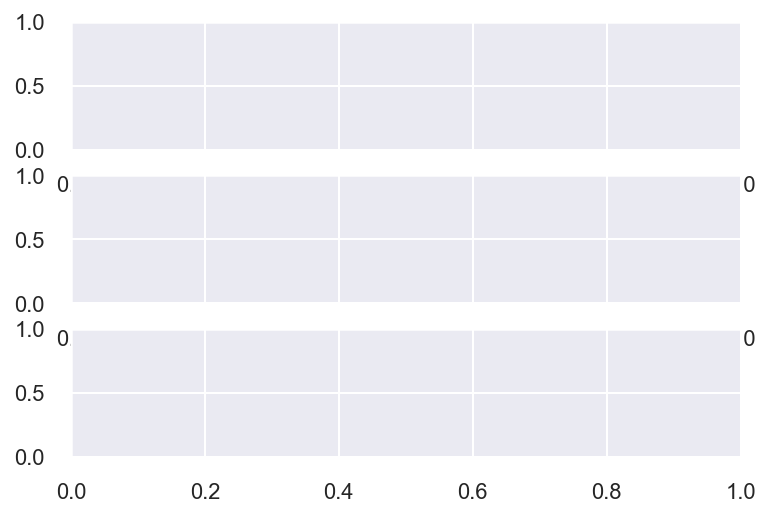

In [15]:
fig, axs = plt.subplots(nrows=3, ncols=1)

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    # Creating SilhouetteVisualizer for K-means
    visualizer = SilhouetteVisualizer(kmeans, ax=axs[0], is_fitted=True, legend=True)
    visualizer.fit(X_projected)
    # Setting subplot legends via axis
    axs[0].legend([f'{visualizer.n_clusters_} clusters, Score={visualizer.silhouette_score_:.3f}'],
                                                loc="upper right", frameon=True, fontsize=10)
    # Setting subplot x and y labels
    axs[0].set(xlabel='silhouette coefficient values', ylabel='cluster label')
    axs[0].set_title("Silhouette Plot for K-Means Clustering", fontsize=10)

    # Creating SilhouetteVisualizer for Agglomerative Clustering
    visualizer = agc_SilhouetteVisualizer(agc, ax=axs[1], is_fitted=True, legend=True)
    visualizer.fit(X_projected)
    axs[1].legend([f'{visualizer.n_clusters_} clusters, Score={visualizer.silhouette_score_:.3f}'],
                                                loc="upper right", frameon=True, fontsize=10)
    # Setting subplot x and y labels
    axs[1].set(xlabel='silhouette coefficient values', ylabel='cluster label')
    axs[1].set_title("Silhouette Plot for Agglomerative Clustering", fontsize=10)

    # Creating SilhouetteVisualizer for DBSCAN
    visualizer = db_SilhouetteVisualizer(db, ax=axs[2], is_fitted=True, legend=True)
    visualizer.fit(X_projected)
    axs[2].legend([f'{visualizer.n_clusters_} clusters, Score={visualizer.silhouette_score_:.3f}'],
                                                loc="upper right", frameon=True, fontsize=10)
    # Setting subplot x and y labels
    axs[2].set(xlabel='silhouette coefficient values', ylabel='cluster label')
    axs[2].set_title("Silhouette Plot for DBSCAN", fontsize=10)


#### Comments

- At first glance, it appears that both $K$-$Means$ and $AgglomerativeClustering$ produce the best results when the average silhouette coefficient alone is used as an assay, because they yield higher scores relative to $DBSCAN$. 

- However, it would be naive to completely rule out the $DBSCAN$ algorithm based on this alone. This is due to wide fluctuations in the thickness of the silhouette plots for the $K$-$Means$ and $AgglomerativeClustering$ algorithms predicting $n$_$clusters$ = $3$.  

- Since the ground truth label assignments are known, the performs of all three clustering algorithms can further be evaluated using the following metrics;

    - $Adjusted$ $Rand$ $Index$ ($ARI$):
    
        - This measures the similarity of the two data clusterings bouded below by 0.0 and above by 1.0
        - Perfect labeling is scored 1.0
        
    - $Adjusted$ $Mutual$ $Information$ ($AMI$):
    
        - Similar to $ARI$, This measures agreement of the two data clusterings, ignoring permutations, bouded below by 0.0 and above by 1.0
        - Perfect labeling is scored 1.0   
        
    - $Homogeneity$ and $Completeness$:
    
        - Homogeneity is a measure of the purity of each cluster. Checks if each cluster contains only members of a single class. This is boudned below by 0.0 and above by 1.0
        - Completeness captures if all members of a given class are assigned to the same cluster. This is also boudned below by 0.0 and above by 1.0 
        - Their harmonic mean called $V$-$measure$
        
    - Mathematical formalisms of these metrics can be found [here](https://scikit-learn.org/stable/modules/clustering.html#silhouette-coefficient)

In [ ]:
metrics_on_data = pd.DataFrame(columns=["ARI", "AMI", "Homogeneity", "Completeness", "Silhouette"], 
                                   index=["K-Means", "Agglomerative Clustering", "DBSCAN"],
                                   dtype=float)


metrics_on_data.loc["K-Means", "ARI"] = metrics.adjusted_rand_score(y_kmeans, flags)
metrics_on_data.loc["K-Means", "AMI"] = metrics.adjusted_mutual_info_score(y_kmeans, flags)
metrics_on_data.loc["K-Means", "Homogeneity"] = metrics.homogeneity_score(y_kmeans, flags)
metrics_on_data.loc["K-Means", "Completeness"] = metrics.completeness_score(y_kmeans, flags)
metrics_on_data.loc["K-Means", "Silhouette"] = metrics.silhouette_score(X_projected, y_kmeans, metric='euclidean')

metrics_on_data.loc["Agglomerative Clustering", "ARI"] = metrics.adjusted_rand_score(y_agc, flags)
metrics_on_data.loc["Agglomerative Clustering", "AMI"] = metrics.adjusted_mutual_info_score(y_agc, flags)
metrics_on_data.loc["Agglomerative Clustering", "Homogeneity"] = metrics.homogeneity_score(y_agc, flags)
metrics_on_data.loc["Agglomerative Clustering", "Completeness"] = metrics.completeness_score(y_agc, flags)
metrics_on_data.loc["Agglomerative Clustering", "Silhouette"] = metrics.silhouette_score(X_projected, y_agc, metric='euclidean')

metrics_on_data.loc["DBSCAN", "ARI"] = metrics.adjusted_rand_score(y_db, flags)
metrics_on_data.loc["DBSCAN", "AMI"] = metrics.adjusted_mutual_info_score(y_db, flags)
metrics_on_data.loc["DBSCAN", "Homogeneity"] = metrics.homogeneity_score(y_db, flags)
metrics_on_data.loc["DBSCAN", "Completeness"] = metrics.completeness_score(y_db, flags)
metrics_on_data.loc["DBSCAN", "Silhouette"] = metrics.silhouette_score(X_projected, y_db, metric='euclidean')

### Metric Heatmap

In [ ]:
sns.heatmap(data=metrics_on_data, annot=True)

#### Comments

- The heatmap shows that of the three algorithms, $DBSCAN$ has the highest scores ($approx$ $1$) for the $ARI$, $AMI$, $Homogeneity$ and $Completeness$ metrics and the lowest $Silhouette$ $Score$. 

- By virtue of their definition, this means that despite the comparatively lower $Silhouette$ $Score$, the $DBSCAN$ clustering algorithm, with $n$_$clusters$ = $2$, yields the predictions with the highest aggrements and similarity to the ground truth labels while maintining the purity of each cluster and ensuring that as many memebers of a given class are are assigned to the correct cluster for completeness. 

- Therefore, the optimal clustering model for this problem is the $DBSCAN$ algorithm with $min$_$samples$ = $300$ and $eps$ = $6.19$ which yields $n$_$clusters$ = $2$.

- As seen in previous silhouette analysis, It is worth noting that similar results can be obtained with the $K$_$means$ and $Agglomerative$ $Clustering$ algortithms trained with $n$_$clusters$ = $2$